import everything

In [2]:
import os
import cv2
import math
import scipy
import numpy as np
import pandas as pd
import nibabel as nib
from PIL import Image
from skimage import measure
import matplotlib.pyplot as plt
from skimage.color import label2rgb
from skimage.transform import resize
from skimage.util import img_as_float
from skimage.segmentation import slic
from scipy.spatial.distance import cdist
from sklearn.metrics import jaccard_score
from skimage.measure import label, regionprops
from openniftiimages import load_and_display_nifti
from scipy.spatial.distance import directed_hausdorff
from skimage.segmentation import find_boundaries, mark_boundaries

read the file to get patient ID and the slices used

In [3]:
patient_info_file = r'G:\Annekoos Schaap - code\Data\All_imaging_features_NKI.xlsx'
base_nifti_path = r'G:\NKI dataset\Data_nifti'

# Read the patient info
patient_info_df = pd.read_excel(patient_info_file)

read the mask area coordinates

In [4]:
# read Excel
filename = 'coordinates.xlsx'
df = pd.read_excel(filename, sheet_name='Sheet1', header=None)
filename_1 = 'coordinates_1.xlsx'
df_1 = pd.read_excel(filename_1, sheet_name='Sheet1', header=None)
print(df)

print(len(df))
print(len(patient_info_df))

      0    1    2    3
0   193  199  370  298
1   137  139  342  276
2   177  197  352  292
3   153  245  352  360
4   175  195  340  316
5   173  205  332  308
6   183  171  324  270
7   161  187  346  318
8   183  201  348  306
9   175  205  348  312
10  177  199  346  334
11  141  209  360  340
12  177  225  366  338
13  143  159  362  330
14  169  189  338  302
15  193  231  346  336
16  159  203  338  310
17  157  215  350  318
18  189  231  336  312
19  175  267  342  384
20  195  233  346  352
21  187  227  342  306
22  183  221  344  320
23  161  171  384  304
24  183  245  346  326
25  173  221  352  342
26   81   92  164  146
27  188   89  387  263
28  203  183  373  331
29  303  295  410  371
30  298  276  415  355
31  284  312  415  412
32  268  262  415  382
33  309  342  401  415
34  303  295  385  371
35
35


In [5]:
dice_score_all = []
dice_score_from_jaccard_all = []
hausdorff_dist_all = []
asd_all = []
alpha_all = []

In [6]:
metrics_data = {
    'patient_name': [],
    'n_segment': [],
    'dice_score': [],
    'hausdorff_dist': [],
    'asd': [],
    'alpha': []
}

from the table given, go through the columns of patient name and slice.
combine the path of T2.nii for each patient --> 'nifti_path'
load the .nii file and reach for the data
make the slice rotated to the right angel and rescale the image --> 'rescaled_image'
corrupt the image based on the coordinates --> 'region'
apply SLIC within the corrupted image: 'segments' are the labels of all superpixels from 1; 'boundaries_1' is a boolen matrix marking boundaries and other areas; 'image_with_boundaries_1' is a RGB image overlapping the image and the boundaries
read the prostate mask from the path --> 'mat_file_path'
keep the mask as boolen and corrupt the mask according to the coordinates
find the boundaries of the prostate mask --> 'prostate_boundaries'


In [7]:
# Define the threshold
threshold = 0.6

In [8]:
def extract_boundary_points(mask):
    if mask.ndim != 2 or mask.size == 0:
        print("掩模形状无效:", mask.shape)
        return np.array([])  # 如果掩模不是二维或为空，则返回一个空数组

    contours = measure.find_contours(mask, level=0.5)
    points = []
    for contour in contours:
        for point in contour:
            points.append(point)
    return np.array(points)

In [9]:
def calculate_metrics(predicted_mask, prostate_mask):

    # Dice score 
    dice_score = 2 * np.sum(predicted_mask & prostate_mask) / (np.sum(predicted_mask) + np.sum(prostate_mask))

    # Jaccard index Dice score: 2 * Jaccard index / (1 + Jaccard index)
    jaccard_index = jaccard_score(prostate_mask.flatten(), predicted_mask.flatten())
    dice_score_from_jaccard = 2 * jaccard_index / (1 + jaccard_index)

    # Hausdorff distance
    u = np.transpose(np.nonzero(prostate_mask))
    v = np.transpose(np.nonzero(predicted_mask))
    hausdorff_dist = max(directed_hausdorff(u, v)[0], directed_hausdorff(v, u)[0])

    print(prostate_mask.shape)
    print(predicted_mask.shape)

    return dice_score, dice_score_from_jaccard, hausdorff_dist

(704, 704)
(704, 704)
(111, 122)
(90, 99)


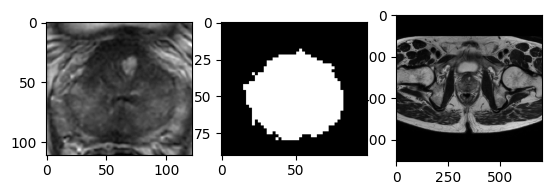

In [10]:
path = r'G:\NKI dataset\Data_nifti\MRI056\NIFTIs\T2.nii'
nifti_image = nib.load(path)
data_nifti = nifti_image.get_fdata()

mat_file_path_1 = r'G:\NKI dataset\Data_nifti\logic_adjusted_masks\adjusted_patient_MRI056\adjusted_prostate_slice_MRI056\adjusted_prostate_slice_12.mat'
mat_1 = scipy.io.loadmat(mat_file_path_1)
prostate_mask_1 = mat_1['logic_image']


image_slice_1 = data_nifti[:, :, 11]
image_nifti_1 = np.rot90(image_slice_1, 3)
image_nifti_1 = np.fliplr(image_nifti_1)
minni_1 = np.min(image_nifti_1)
maxni_1 = np.max(image_nifti_1)
rescaled_image_1 = ((image_nifti_1 - minni_1) / (maxni_1 - minni_1)) * 255
rescaled_image_1 = rescaled_image_1.astype(np.uint8)
area_1 = rescaled_image_1[270:381, 283:405]
print(image_nifti_1.shape)
print(rescaled_image_1.shape)
print(area_1.shape)

prostate_mask_1 = prostate_mask_1.astype(bool)
prostate_mask_1 = prostate_mask_1[190:280, 201:300]
print(prostate_mask_1.shape)

plt.figure()
plt.subplot(1,3,1)
plt.imshow(area_1,cmap='gray')

plt.subplot(1,3,2)
plt.imshow(prostate_mask_1,cmap='gray')

plt.subplot(1,3,3)
plt.imshow(rescaled_image_1,cmap='gray')


In [11]:
def calculate_asd(mask1, mask2):
    # 提取两个掩模的边界点
    points1 = extract_boundary_points(mask1)
    points2 = extract_boundary_points(mask2)

    print(points1.shape)
    print(points2.shape)
    
    # 计算点集之间的距离
    distances_1_to_2 = cdist(points1, points2, metric='euclidean')
    distances_2_to_1 = cdist(points2, points1, metric='euclidean')
    
    # 找到最短距离并计算平均值
    min_distances_1_to_2 = np.min(distances_1_to_2, axis=1)
    min_distances_2_to_1 = np.min(distances_2_to_1, axis=1)
    
    # 计算两个方向的平均表面距离
    asd_1_to_2 = np.mean(min_distances_1_to_2)
    asd_2_to_1 = np.mean(min_distances_2_to_1)
    
    # 返回双向平均表面距离
    return (asd_1_to_2 + asd_2_to_1) / 2

In [12]:
# for index, row in patient_info_df.iterrows():
#     for n_segment in range(20, 51, 5):
#         patient_name = row['Patient name ']
#         slice_no = int(np.floor(row['Slice no. ']))  # Assuming 'Slice no.' column contains integers
#         print(f"Processing {patient_name}, Slice {slice_no}...")
#         # Construct the path to the NIfTI file
#         nifti_path = os.path.join(base_nifti_path, patient_name, 'NIFTIs', 'T2.nii')
        
#         # Load the NIfTI image
#         nifti_image = nib.load(nifti_path)
#         data_nifti = nifti_image.get_fdata()
        
#         # Check if the number of dimensions is correct
#         if data_nifti.ndim == 3:
#             # Get the specific slice
#             image_slice = data_nifti[:, :, slice_no - 1]
            
#             # Process the image slice
#             image_nifti = np.rot90(image_slice, 3)
#             image_nifti = np.fliplr(image_nifti)
#             minni = np.min(image_nifti)
#             maxni = np.max(image_nifti)
#             rescaled_image = ((image_nifti - minni) / (maxni - minni)) * 255
#             rescaled_image = rescaled_image.astype(np.uint8)

#             # Get coordinates for the current patient
#             # Assuming each patient has a corresponding row in the coordinates Excel file
            
#             minX, minY, maxX, maxY = df.iloc[index, :4]
#             # minX_1, minY_1, maxX_1, maxY_1 = df_1.iloc[index, :4]
            
#             # Crop the region from the rescaled image
#             # Ensure that the indices do not go out of bounds
#             y_min = max(minY - 25, 0)
#             y_max = min(maxY + 10, rescaled_image.shape[0])
#             x_min = max(minX - 20, 0)
#             x_max = min(maxX + 20, rescaled_image.shape[1])
#             area = rescaled_image[y_min:y_max, x_min:x_max]
#             print(area.shape)

#             mat_file_path = os.path.join(base_nifti_path, 'logic_adjusted_masks', f'adjusted_patient_{patient_name}', f'adjusted_prostate_slice_{patient_name}', f'adjusted_prostate_slice_{slice_no}.mat')
#             mat = scipy.io.loadmat(mat_file_path)
#             prostate_mask = mat['logic_image']

#             # y_min_1 = max(minY_1 - 25, 0)
#             # y_max_1 = min(maxY_1 + 10, prostate_mask.shape[0])
#             # x_min_1 = max(minX_1 - 20, 0)
#             # x_max_1 = min(maxX_1 + 20, prostate_mask.shape[1])
                    
#             # prostate_mask = prostate_mask[y_min_1:y_max_1, x_min_1:x_max_1]
#             prostate_mask = prostate_mask[y_min:y_max, x_min:x_max]

#             if prostate_mask.shape != area.shape:
#                 prostate_mask = resize(prostate_mask, area.shape, order=0, preserve_range=True, anti_aliasing=False).astype(bool)

#             print(prostate_mask.shape)

#             pixel_amount = np.sum(prostate_mask)
            
#             segments = slic(area, n_segments=n_segment, compactness=0.05, sigma=1, start_label=1, channel_axis=None)
#             boundaries_1 = find_boundaries(segments, mode='inner')
#             image_with_boundaries_1 = mark_boundaries(area, boundaries_1, color=(1, 0, 0))
#             alpha = -math.log(n_segment/pixel_amount)

#             predicted_mask = np.zeros_like(prostate_mask)
#             print(area.dtype, area.shape)
            
#             for region in regionprops(label(segments)):
#                 # Extract the superpixel region
#                 superpixel = (segments == region.label)
                
#                 # Calculate overlap with the prostate mask
#                 overlap = np.sum(superpixel & prostate_mask) / np.sum(superpixel)
                
#                 # If overlap exceeds the threshold, consider it as part of the prostate
#                 if overlap > threshold:
#                     predicted_mask[superpixel] = 1

#             prostate_boundaries = find_boundaries(prostate_mask, mode='inner')
#             prediction_boundaries = find_boundaries(predicted_mask, mode='inner')
#             print(area.dtype, area.shape)

#             image_with_boundaries_2 = mark_boundaries(image_with_boundaries_1, prostate_boundaries, color=(0, 0, 1))
#             image_with_boundaries_3 = mark_boundaries(image_with_boundaries_2, prediction_boundaries, color=(0, 1, 0))

#             plt.figure(figsize=(10, 10))
#             plt.imshow(image_with_boundaries_3, cmap='gray')
#             plt.axis('off')

#             save_folder = r'C:\Users\alexg\Desktop\study\graduation project\code\maskc425'
#             os.makedirs(save_folder, exist_ok=True)
#             save_path = os.path.join(save_folder, f'patient_{patient_name}_comparison_{n_segment}.png')

#             plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
#             plt.close()
#             save_path

#             dice_score, dice_score_from_jaccard, hausdorff_dist = calculate_metrics(predicted_mask, prostate_mask)
#             asd = calculate_asd(predicted_mask, prostate_mask)

#             # dice_score_all.append(dice_score)
#             # dice_score_from_jaccard_all.append(dice_score_from_jaccard)
#             # hausdorff_dist_all.append(hausdorff_dist)
#             # asd_all.append(asd)
#             # alpha_all.append(alpha)

#         metrics_data['patient_name'].append(patient_name)
#         metrics_data['n_segment'].append(n_segment)
#         metrics_data['dice_score'].append(dice_score)
#         metrics_data['hausdorff_dist'].append(hausdorff_dist)
#         metrics_data['asd'].append(asd)
#         metrics_data['alpha'].append(alpha)

#         print(f"Finished processing {patient_name}, Slice {slice_no}.\n")
    
# print("All patients processed. Calculating metrics...")



In [13]:
for index, row in patient_info_df.iterrows():
    for n_segment in range(20, 51, 5):
        patient_name = row['Patient name ']
        slice_no = int(np.floor(row['Slice no. ']))  # Assuming 'Slice no.' column contains integers
        print(f"Processing {patient_name}, Slice {slice_no}...")
        # Construct the path to the NIfTI file
        nifti_path = os.path.join(base_nifti_path, patient_name, 'NIFTIs', 'T2.nii')
        
        # Load the NIfTI image
        nifti_image = nib.load(nifti_path)
        data_nifti = nifti_image.get_fdata()
        
        # Check if the number of dimensions is correct
        if data_nifti.ndim == 3:
            # Get the specific slice
            image_slice = data_nifti[:, :, slice_no - 1]
            
            # Process the image slice
            image_nifti = np.rot90(image_slice, 3)
            image_nifti = np.fliplr(image_nifti)
            minni = np.min(image_nifti)
            maxni = np.max(image_nifti)
            rescaled_image = ((image_nifti - minni) / (maxni - minni)) * 255
            rescaled_image = rescaled_image.astype(np.uint8)

            # Get coordinates for the current patient
            # Assuming each patient has a corresponding row in the coordinates Excel file
            
            minX, minY, maxX, maxY = df.iloc[index, :4]
            # minX_1, minY_1, maxX_1, maxY_1 = df_1.iloc[index, :4]
            
            # Crop the region from the rescaled image
            # Ensure that the indices do not go out of bounds
            y_min = max(minY - 25, 0)
            y_max = min(maxY + 10, rescaled_image.shape[0])
            x_min = max(minX - 20, 0)
            x_max = min(maxX + 20, rescaled_image.shape[1])
            area = rescaled_image[y_min:y_max, x_min:x_max]
            print(area.shape)

            # mat_file_path = os.path.join(base_nifti_path, 'logic_adjusted_masks', f'adjusted_patient_{patient_name}', f'adjusted_prostate_slice_{patient_name}', f'adjusted_prostate_slice_{slice_no}.mat')
            # mat = scipy.io.loadmat(mat_file_path)
            # prostate_mask = mat['logic_image']

            mat_file_path = os.path.join(r'C:\Users\alexg\Desktop\study\graduation project\code\prostate_ROI', f'{patient_name}_{slice_no}_prostate_ROI.png')
            image = cv2.imread(mat_file_path, cv2.IMREAD_GRAYSCALE)
            prostate_mask = image.astype(bool)

            # y_min_1 = max(minY_1 - 25, 0)
            # y_max_1 = min(maxY_1 + 10, prostate_mask.shape[0])
            # x_min_1 = max(minX_1 - 20, 0)
            # x_max_1 = min(maxX_1 + 20, prostate_mask.shape[1])
                    
            # prostate_mask = prostate_mask[y_min_1:y_max_1, x_min_1:x_max_1]
            prostate_mask = prostate_mask[y_min:y_max, x_min:x_max]

            if prostate_mask.shape != area.shape:
                prostate_mask = resize(prostate_mask, area.shape, order=0, preserve_range=True, anti_aliasing=False).astype(bool)

            print(prostate_mask.shape)

            pixel_amount = np.sum(prostate_mask)
            
            segments = slic(area, n_segments=n_segment, compactness=0.05, sigma=1, start_label=1, channel_axis=None)
            boundaries_1 = find_boundaries(segments, mode='inner')
            image_with_boundaries_1 = mark_boundaries(area, boundaries_1, color=(1, 0, 0))
            alpha = -math.log(n_segment/pixel_amount)

            predicted_mask = np.zeros_like(prostate_mask)
            print(area.dtype, area.shape)
            
            for region in regionprops(label(segments)):
                # Extract the superpixel region
                superpixel = (segments == region.label)
                
                # Calculate overlap with the prostate mask
                overlap = np.sum(superpixel & prostate_mask) / np.sum(superpixel)
                
                # If overlap exceeds the threshold, consider it as part of the prostate
                if overlap > threshold:
                    predicted_mask[superpixel] = 1

            prostate_boundaries = find_boundaries(prostate_mask, mode='inner')
            prediction_boundaries = find_boundaries(predicted_mask, mode='inner')
            print(area.dtype, area.shape)

            image_with_boundaries_2 = mark_boundaries(image_with_boundaries_1, prostate_boundaries, color=(0, 0, 1))
            image_with_boundaries_3 = mark_boundaries(image_with_boundaries_2, prediction_boundaries, color=(0, 1, 0))

            plt.figure(figsize=(10, 10))
            plt.imshow(image_with_boundaries_3, cmap='gray')
            plt.axis('off')

            save_folder = r'C:\Users\alexg\Desktop\study\graduation project\code\maskc425'
            os.makedirs(save_folder, exist_ok=True)
            save_path = os.path.join(save_folder, f'patient_{patient_name}_comparison_{n_segment}.png')

            plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
            plt.close()
            save_path

            dice_score, dice_score_from_jaccard, hausdorff_dist = calculate_metrics(predicted_mask, prostate_mask)
            asd = calculate_asd(predicted_mask, prostate_mask)

            # dice_score_all.append(dice_score)
            # dice_score_from_jaccard_all.append(dice_score_from_jaccard)
            # hausdorff_dist_all.append(hausdorff_dist)
            # asd_all.append(asd)
            # alpha_all.append(alpha)

        metrics_data['patient_name'].append(patient_name)
        metrics_data['n_segment'].append(n_segment)
        metrics_data['dice_score'].append(dice_score)
        metrics_data['hausdorff_dist'].append(hausdorff_dist)
        metrics_data['asd'].append(asd)
        metrics_data['alpha'].append(alpha)

        print(f"Finished processing {patient_name}, Slice {slice_no}.\n")
    
print("All patients processed. Calculating metrics...")



Processing MRI002, Slice 10...
(134, 217)
(134, 217)
uint8 (134, 217)
uint8 (134, 217)
(134, 217)
(134, 217)
(1169, 2)
(581, 2)
Finished processing MRI002, Slice 10.

Processing MRI002, Slice 10...
(134, 217)
(134, 217)
uint8 (134, 217)
uint8 (134, 217)
(134, 217)
(134, 217)
(1177, 2)
(581, 2)
Finished processing MRI002, Slice 10.

Processing MRI002, Slice 10...
(134, 217)
(134, 217)
uint8 (134, 217)
uint8 (134, 217)
(134, 217)
(134, 217)
(897, 2)
(581, 2)
Finished processing MRI002, Slice 10.

Processing MRI002, Slice 10...
(134, 217)
(134, 217)
uint8 (134, 217)
uint8 (134, 217)
(134, 217)
(134, 217)
(1067, 2)
(581, 2)
Finished processing MRI002, Slice 10.

Processing MRI002, Slice 10...
(134, 217)
(134, 217)
uint8 (134, 217)
uint8 (134, 217)
(134, 217)
(134, 217)
(981, 2)
(581, 2)
Finished processing MRI002, Slice 10.

Processing MRI002, Slice 10...
(134, 217)
(134, 217)
uint8 (134, 217)
uint8 (134, 217)
(134, 217)
(134, 217)
(969, 2)
(581, 2)
Finished processing MRI002, Slice 10.

P

In [14]:
# 使用pandas创建DataFrame
evaluation_save = pd.DataFrame(metrics_data)

with pd.ExcelWriter('table9.xlsx') as writer:
    evaluation_save.pivot_table(index=['patient_name', 'n_segment'], values='dice_score').unstack().to_excel(writer, sheet_name='Dice Scores')
    evaluation_save.pivot_table(index=['patient_name', 'n_segment'], values='hausdorff_dist').unstack().to_excel(writer, sheet_name='Hausdorff Distances')
    evaluation_save.pivot_table(index=['patient_name', 'n_segment'], values='asd').unstack().to_excel(writer, sheet_name='ASD')
    evaluation_save.pivot_table(index=['patient_name', 'n_segment'], values='alpha').unstack().to_excel(writer, sheet_name='Alpha')

# # 指定要写入的Excel文件路径
# evaluation_save_path = r'C:\Users\alexg\Desktop\study\graduation project\code\table7.xlsx'

# # 将DataFrame写入Excel文件，不保存行索引
# evaluation_save.to_excel(evaluation_save_path, index=False)

print('Data saved to Excel file successfully.')

Data saved to Excel file successfully.


Evaluation

In [22]:
path_e = r'C:\Users\alexg\Desktop\study\graduation project\code\table9.xlsx'

In [23]:
df_0 = pd.read_excel(path_e, sheet_name='Dice Scores', header=None)
df_1 = pd.read_excel(path_e, sheet_name='Dice Scores', header=None).drop(columns=[0])
df_2 = pd.read_excel(path_e, sheet_name='Hausdorff Distances', header=None).drop(columns=[0])
df_3 = pd.read_excel(path_e, sheet_name='ASD', header=None).drop(columns=[0])
df_4 = pd.read_excel(path_e, sheet_name='Alpha', header=None).drop(columns=[0])

In [24]:
print(df_1)

           1         2         3         4         5         6         7
0   0.813307  0.800860  0.763799  0.849873  0.836541  0.877394  0.872182
1   0.759342  0.782264  0.800032  0.856561  0.814322  0.875983  0.920090
2   0.810292  0.829628  0.858988  0.862314  0.903676  0.910270  0.907693
3   0.919710  0.940786  0.832409  0.918827  0.928746  0.916219  0.932351
4   0.759737  0.828057  0.815975  0.858349  0.891969  0.890415  0.893627
5   0.849857  0.880348  0.841272  0.813070  0.898548  0.892356  0.889886
6   0.828884  0.817584  0.823529  0.884598  0.814477  0.881872  0.889937
7   0.838088  0.778436  0.886493  0.880360  0.852041  0.847571  0.898282
8   0.707743  0.780292  0.873782  0.814784  0.845347  0.880913  0.891004
9   0.759456  0.827193  0.860841  0.855635  0.888388  0.892481  0.873678
10  0.880777  0.900076  0.846378  0.888974  0.895260  0.889210  0.889142
11  0.715264  0.821615  0.847827  0.868357  0.906075  0.895596  0.920219
12  0.834688  0.882392  0.929166  0.862880  0.84490

In [18]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [19]:
# 患者编号
patients = df_0[0]

# PCA和标准化
scaler = StandardScaler()
pca = PCA()

# 为每个患者执行PCA
results = []
for patient_idx in range(df_1.shape[0]):
    # 合并每个患者的评估数据
    p1 = scaler.fit_transform(df_1.iloc[patient_idx, :].values.reshape(1, -1))
    p2 = scaler.fit_transform(df_2.iloc[patient_idx, :].values.reshape(1, -1))
    p3 = scaler.fit_transform(df_3.iloc[patient_idx, :].values.reshape(1, -1))
    patient_data = np.concatenate([p1, p2, p3], axis=1)

    scaled_data = scaler.fit_transform(patient_data)
    # 应用PCA
    pca.fit(scaled_data)
    # 收集PCA结果
    results.append({
        'Patient ID': patients[patient_idx],
        'Explained Variance Ratio': pca.explained_variance_ratio_,
        'Most Influential Feature': np.argmax(pca.components_[0])
    })

# 将结果转换为DataFrame
results_df = pd.DataFrame(results)
print(results_df)

ValueError: could not convert string to float: 'dice_score'

In [25]:
df_1.iloc[:,0]

0     0.813307
1     0.759342
2     0.810292
3     0.919710
4     0.759737
5     0.849857
6     0.828884
7     0.838088
8     0.707743
9     0.759456
10    0.880777
11    0.715264
12    0.834688
13    0.800412
14    0.814331
15    0.831424
16    0.776209
17    0.791147
18    0.617138
19    0.862648
20    0.824058
21    0.921805
22    0.890636
23    0.662747
24    0.637527
25    0.880472
26    0.845209
27    0.855185
28    0.783104
29    0.766861
30    0.743460
31    0.905181
32    0.866950
33    0.807893
34    0.794935
Name: 1, dtype: float64

In [ ]:
x_pca = pca.fit_transform(patient_data)

expV = pca.explained_variance_
total_V = expV.sum()

print(expV, total_V)

[nan] nan


c:\Users\alexg\anaconda3\envs\abpco\Lib\site-packages\sklearn\decomposition\_pca.py:557: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)


对每个患者进行PCA

In [26]:
df_D = (df_1 - df_1.min()) / (df_1.max() - df_1.min())
df_H = 1 - ((df_2 - df_2.min()) / (df_2.max() - df_2.min()))
df_A = 1 - (df_3 - df_3.min()) / (df_3.max() - df_3.min())

In [27]:
print(df_D)
print(df_D.max())

           1         2         3         4         5         6         7
0   0.643880  0.430091  0.510647  0.545308  0.194180  0.580889  0.453915
1   0.466752  0.354346  0.617867  0.589415  0.000000  0.572416  0.806890
2   0.633983  0.547259  0.792330  0.627348  0.780897  0.778389  0.715551
3   0.993125  1.000000  0.713677  1.000000  1.000000  0.814127  0.897224
4   0.468047  0.540860  0.665047  0.601203  0.678593  0.659111  0.611919
5   0.763848  0.753841  0.739906  0.302626  0.736081  0.670772  0.584354
6   0.695008  0.498204  0.687401  0.774293  0.001350  0.607791  0.584732
7   0.725219  0.338756  0.873722  0.746346  0.329643  0.401736  0.646212
8   0.297388  0.346315  0.836109  0.313931  0.271137  0.602032  0.592594
9   0.467126  0.537344  0.797814  0.583305  0.647293  0.671523  0.464936
10  0.865335  0.834193  0.755015  0.803149  0.707347  0.651874  0.578875
11  0.322077  0.514623  0.759303  0.667198  0.801868  0.690238  0.807838
12  0.714058  0.762166  1.000000  0.631081  0.26729

In [ ]:
# ideal_best = np.array([df_D.max(), df_H.max(), df_A.max()])
# ideal_worst = np.array([df_D.min(), df_H.min(), df_A.min()])

In [ ]:
#ideal_best = np.ones((35,17))
#ideal_worst = np.zeros((35,17))

In [28]:
ideal_best = np.ones((35,7))
ideal_worst = np.zeros((35,7))

In [29]:
print(ideal_best)

[[1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]]


In [30]:
Distance_to_Best = np.sqrt((df_D - ideal_best) ** 2 + (df_H - ideal_best) ** 2 + (df_A - ideal_best) ** 2)
Distance_to_worst = np.sqrt((df_D - ideal_worst) ** 2 + (df_H - ideal_worst) ** 2 + (df_A - ideal_worst) ** 2)

closeness= Distance_to_worst / (Distance_to_Best + Distance_to_worst)

In [31]:
print(closeness.shape)

(35, 7)


In [32]:
df_ids = df_0.iloc[:, 0]

In [33]:
best_alphas_topsis = np.max(closeness, axis=1)
best_alphas_index = np.argmax(closeness, axis=1)
for df_id,(value, index) in zip(df_ids, zip(best_alphas_topsis,best_alphas_index)):
    print(f"patient {df_id}: achieves the best segmentation when alpha is {value:.4f} and n_segment is {index*5 + 20} ")

patient MRI002: achieves the best segmentation when alpha is 0.7231 and n_segment is 20 
patient MRI006: achieves the best segmentation when alpha is 0.6333 and n_segment is 50 
patient MRI008: achieves the best segmentation when alpha is 0.8339 and n_segment is 40 
patient MRI009: achieves the best segmentation when alpha is 0.9651 and n_segment is 25 
patient MRI012: achieves the best segmentation when alpha is 0.6594 and n_segment is 40 
patient MRI014: achieves the best segmentation when alpha is 0.7999 and n_segment is 25 
patient MRI016: achieves the best segmentation when alpha is 0.7561 and n_segment is 35 
patient MRI018: achieves the best segmentation when alpha is 0.7422 and n_segment is 30 
patient MRI019: achieves the best segmentation when alpha is 0.8055 and n_segment is 30 
patient MRI020: achieves the best segmentation when alpha is 0.7269 and n_segment is 40 
patient MRI021: achieves the best segmentation when alpha is 0.7699 and n_segment is 20 
patient MRI022: achie

In [34]:
results_df = pd.DataFrame({
    'Patient ID': df_ids,
    'Best Alpha Value': best_alphas_topsis,
    'Best n_segment Value': best_alphas_index * 5 + 20  # 计算n_segment值
})

In [35]:
# 指定Excel文件路径
excel_path = r'C:/Users/alexg/Desktop/study/graduation project/code/results25.xlsx'

# 将DataFrame写入到Excel文件
results_df.to_excel(excel_path, index=False)  # 设置index=False来避免添加未命名的索引列到文件

print('Data saved to Excel successfully.')

Data saved to Excel successfully.
